## Initial Data Exploration Kuzushiji

Once you've identified a Use Case and Data Set it is time to get familiar with data. In the process model this task is called Initial Data Exploration. Please take a minute or two to (re)visit the following lecture

https://www.coursera.org/learn/data-science-methodology

Module 2 - Data Understanding

Please also revisit:

http://coursera.org/learn/ds

Module 3 - Mathematical Foundations and Module 4 - Visualizations

Given the lectures above, please create statistics and visualization on your Data Set to identify good columns for modeling, potential data quality issues and anticipate potential feature transformations necessary.

Create a jupyter notebook where you document your code and include visualizations as first deliverable. Please also stick to the naming conventions explained in the the process model manual.

So, the most important reasons / steps are:

Identify quality issues (e.g. missing values, wrong measurements, …)

Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)

Get an idea on the value distribution of your data using statistical measures and visualizations

In [1]:
!pip install tensorflow
!pip install seaborn==0.11.1
!pip install Pillow
!pip install python-mnist
!pip install pyspark

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 26.1 MB 17.0 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.0
    Uninstalling scipy-1.5.0:
      Successfully uninstalled scipy-1.5.0
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDepreca

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
import seaborn as sns
from mnist import MNIST
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.image as mping
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from numpy import asarray
import pandas as pd

In [3]:
tf.__version__

'2.1.0'

In [4]:
sns.__version__

'0.11.1'

In [5]:
PIL.__version__

'7.2.0'

In [6]:
# fire up the spark session
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [7]:
# enable arrow which lets us transfrom a pandas dataframe into a pyspark dataframe
spark.conf.set("spark.sql.execution.arrow.enabled","true")

In [8]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
!mv train-images-idx3-ubyte.gz?raw=True train-images-idx3-ubyte.gz
!gunzip train-images-idx3-ubyte.gz
!ls -lahr train-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
!mv train-labels-idx1-ubyte.gz?raw=True train-labels-idx1-ubyte.gz
!gunzip train-labels-idx1-ubyte.gz
!ls -lahr train-labels-idx1-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz?raw=True
!mv t10k-images-idx3-ubyte.gz?raw=True t10k-images-idx3-ubyte.gz
!gunzip t10k-images-idx3-ubyte.gz
!ls -lahr t10k-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz?raw=True
!mv t10k-labels-idx1-ubyte.gz?raw=True t10k-labels-idx1-ubyte.gz
!gunzip t10k-labels-idx1-ubyte.gz
!ls -lahr t10k-labels-idx1-ubyte

--2021-06-10 15:47:24--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18165135 (17M)
Saving to: ‘train-images-idx3-ubyte.gz?raw=True’

train-images-idx3-u 100%[===================>]  17.32M  6.02MB/s    in 2.9s    

2021-06-10 15:47:28 (6.02 MB/s) - ‘train-images-idx3-ubyte.gz?raw=True’ saved [18165135/18165135]

-rw-rw---- 1 wsuser watsonstudio 45M Feb  4  2019 train-images-idx3-ubyte
--2021-06-10 15:47:32--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29497 (29K)
Saving to: ‘train-labels-idx1-ubyte.gz?raw=True’

train-labels-id

In [9]:
url = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist_classmap.csv"
df_classmap = pd.read_csv(url)
df_classmap.head(11)

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


In [10]:
# let's add the sound the character makes for non-Japanese speakers
# just to clarify the function of these characters in spoken Japanese

phonetic = ['o','ki','su','tsu','na','ha','ma','ya','re','wo']
df_classmap['phonetic'] = phonetic
df_classmap

,index,codepoint,char,phonetic
0,0,U+304A,お,o
1,1,U+304D,き,ki
2,2,U+3059,す,su
3,3,U+3064,つ,tsu
4,4,U+306A,な,na
5,5,U+306F,は,ha
6,6,U+307E,ま,ma
7,7,U+3084,や,ya
8,8,U+308C,れ,re
9,9,U+3092,を,wo


In [11]:
!mkdir kmnistdata

In [12]:
!ls -al

total 53688
drwxr-x--- 4 wsuser watsonstudio     4096 Jun 10 15:48 .
drwx------ 1 wsuser watsonstudio     4096 Jun 10 15:46 ..
drwxrwx--- 2 wsuser watsonstudio     4096 Jun 10 15:48 kmnistdata
-rw-rw---- 1 wsuser watsonstudio  7840016 Feb  4  2019 t10k-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    10008 Feb  4  2019 t10k-labels-idx1-ubyte
-rw-rw---- 1 wsuser watsonstudio 47040016 Feb  4  2019 train-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    60008 Feb  4  2019 train-labels-idx1-ubyte
drwxr-x--- 2 wsuser watsonstudio     4096 Jun 10 15:43 .virtual_documents


In [13]:
!cp t10k-images-idx3-ubyte kmnistdata/t10k-images-idx3-ubyte
!cp t10k-labels-idx1-ubyte kmnistdata/t10k-labels-idx1-ubyte
!cp train-images-idx3-ubyte kmnistdata/train-images-idx3-ubyte
!cp train-labels-idx1-ubyte kmnistdata/train-labels-idx1-ubyte

In [14]:
!ls -al kmnistdata

total 53680
drwxrwx--- 2 wsuser watsonstudio     4096 Jun 10 15:48 .
drwxr-x--- 4 wsuser watsonstudio     4096 Jun 10 15:48 ..
-rw-rw---- 1 wsuser watsonstudio  7840016 Jun 10 15:48 t10k-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    10008 Jun 10 15:48 t10k-labels-idx1-ubyte
-rw-rw---- 1 wsuser watsonstudio 47040016 Jun 10 15:48 train-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    60008 Jun 10 15:48 train-labels-idx1-ubyte


In [15]:
data = MNIST('kmnistdata')
train_images, train_labels = data.load_training()
test_images, test_labels = data.load_testing()

In [16]:
print(train_labels[0])
print(train_images[0])

8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 255, 255, 124, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 238, 255, 146, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 203, 255, 220, 14, 0, 0, 0, 11, 132, 95, 187, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 255, 251, 66, 0, 0, 0, 7, 168, 136, 10, 223, 245, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 247, 255, 156, 1, 0, 0, 0, 130, 201, 9, 0, 158, 255, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 212, 255, 226, 22, 0, 0, 0, 79, 240, 38, 0, 0, 143, 255, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 255, 255, 107, 0, 0, 0, 33, 237, 121, 0, 0, 0, 144, 255, 222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 205, 255, 178, 3, 0, 0, 1, 179, 208, 5, 0, 0, 0, 126, 255, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 245, 255, 76, 0, 0, 0, 124, 254, 108, 0, 0, 0, 0, 91, 255, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 255, 239, 12, 0, 0, 62, 250, 225, 8, 0, 0, 0, 0, 78, 255, 197, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
print(train_labels[1])
print(train_images[1])

7
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 134, 162, 155, 49, 0, 63, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 120, 253, 250, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 252, 251, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 107, 210, 241, 121, 133, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 147, 254, 244, 235, 230, 255, 138, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 82,

In [18]:
type(train_labels)

array.array

In [19]:
type(train_images)

list

In [20]:
train_labels.typecode

'B'

In [21]:
# the following output is (address, length) giving current memory address
# and length in elements of the buffer used to hold the array's
# contents

train_labels.buffer_info()

(93972336590048, 60000)

In [22]:
# In the first dataset that we downloaded and loaded above, the data
# is already flattened, which is good for the machine learning model
# but we would like to actaully be able to view the images

# so, the first step here is the convert the data into numpy arrays
# numpy arrays can be used to normalize for the ML model, but also
# numpy arrays are easier to reshape in case we want to actually view 
# the data as images

In [23]:
# transform to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [24]:
# now we should be able to do more data exploration
train_images.shape

(60000, 784)

In [25]:
# the data is already flattened for use in the model, but
# we need to unflatten the data if we want to view and verify 
# that these are actually images of kuzushiji characters

train_images = np.reshape(train_images, (60000, 28, 28))

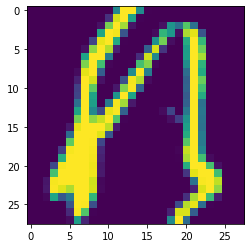

In [26]:
# let's see the image at index 0
plt.figure()
plt.imshow(train_images[0])
plt.show()

In [27]:
df_classmap

,index,codepoint,char,phonetic
0,0,U+304A,お,o
1,1,U+304D,き,ki
2,2,U+3059,す,su
3,3,U+3064,つ,tsu
4,4,U+306A,な,na
5,5,U+306F,は,ha
6,6,U+307E,ま,ma
7,7,U+3084,や,ya
8,8,U+308C,れ,re
9,9,U+3092,を,wo


In [28]:
# so we can see, using the classmap that this character 
# pronounced "re" should be type number 8
train_labels[0]

8

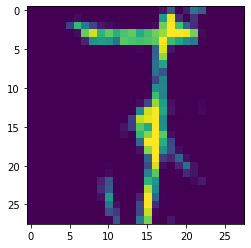

In [29]:
# we can check another one:
plt.figure()
plt.imshow(train_images[5])
plt.show()

In [30]:
# this one is 'su', so according to the classmap
# it should be type 2
train_labels[5]

2

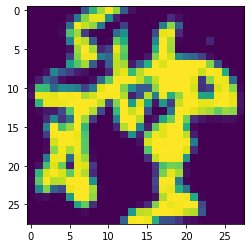

In [31]:
# next
plt.figure()
plt.imshow(train_images[7])
plt.show()

In [32]:
# I cannot visually determine which one it is
# Checking the type:
train_labels[7]

8

7
や ya


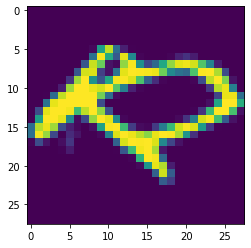

3
つ tsu


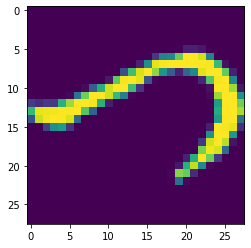

7
や ya


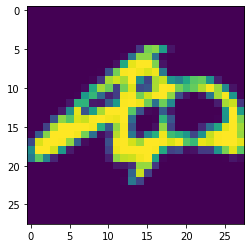

5
は ha


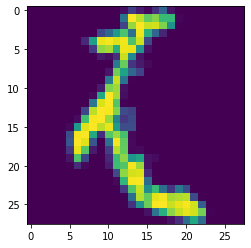

6
ま ma


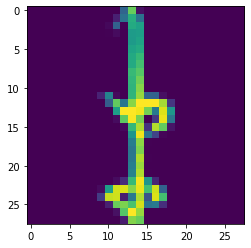

6
ま ma


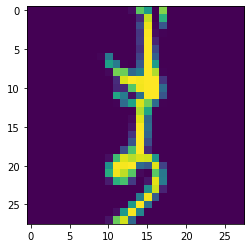

2
す su


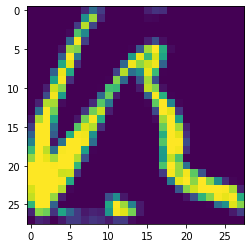

7
や ya


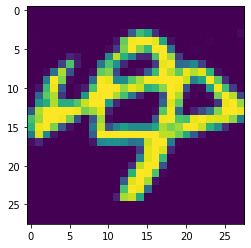

6
ま ma


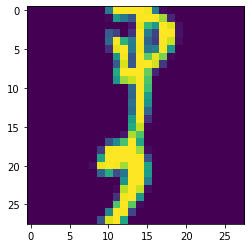

0
お o


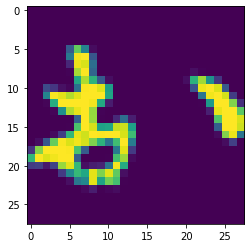

9
を wo


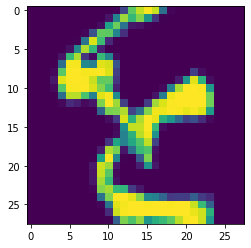

6
ま ma


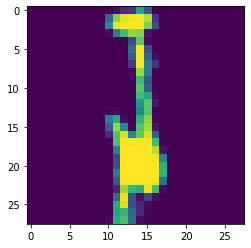

1
き ki


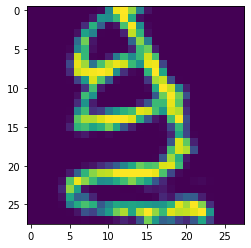

5
は ha


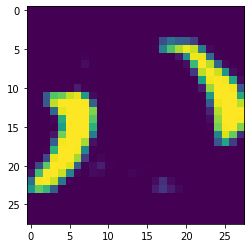

9
を wo


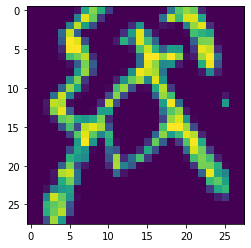

5
は ha


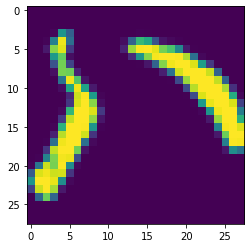

8
れ re


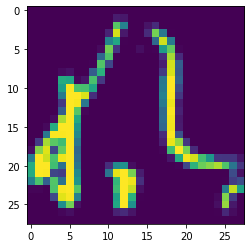

0
お o


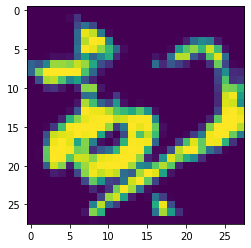

0
お o


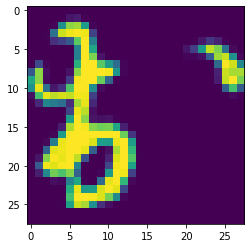

8
れ re


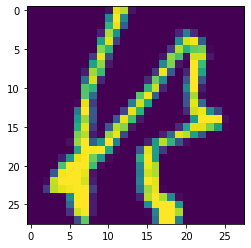

In [33]:
# next we print the class number, the written character, and the phonetic
# for index numbers 20 through 40:
for i in range(20,40):
    print(train_labels[i])
    print(df_classmap.loc[train_labels[i],'char'], df_classmap.loc[train_labels[i],'phonetic'])
    plt.figure()
    plt.imshow(train_images[i])
    plt.show()
    
    i+=1

In [34]:
# So we now we have verified this data is what we want: namely images of kuzushiji characters
# which we can view in "unflattned" format (60000, 28, 28) as images and that we can leave in "flattened" 
# format in two dimensional numpy arrays with dimensions (60000, 784) for use in the ML model

# next we convert the train_labels numpy array to a dataframe

df_train_labels = pd.DataFrame(train_labels)

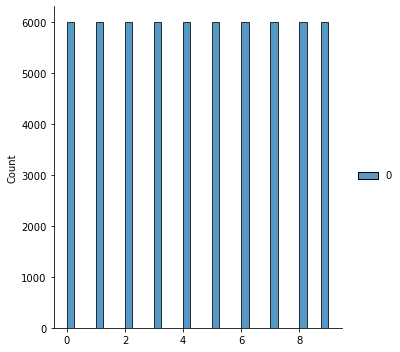

In [35]:
sns.displot(df_train_labels)

In [36]:
# so shows us this is a balanced set

In [37]:
df_train_labels[0].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: 0, dtype: int64

In [38]:
# this confirms the set is perfectly balanced

In [39]:
# next we obtain a slightly more difficult dataset
# which includes 49 classes of kuzushiji instead of just
# 10 classes:

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
!mv k49-train-imgs.npz?raw=True k49-train-imgs.npz
!ls -lahr k49-train-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
!mv k49-train-labels.npz?raw=True k49-train-labels.npz
!ls -lahr k49-train-labels.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz?raw=True
!mv k49-test-imgs.npz?raw=True k49-test-imgs.npz
!ls -lahr k49-test-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz?raw=True
!mv k49-test-labels.npz?raw=True k49-test-labels.npz
!ls -lahr k49-test-labels.npz

--2021-06-10 15:50:15--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66117696 (63M)
Saving to: ‘k49-train-imgs.npz?raw=True’

k49-train-imgs.npz? 100%[===================>]  63.05M  9.17MB/s    in 7.8s    

2021-06-10 15:50:23 (8.10 MB/s) - ‘k49-train-imgs.npz?raw=True’ saved [66117696/66117696]

-rw-rw---- 1 wsuser watsonstudio 64M Feb  4  2019 k49-train-imgs.npz
--2021-06-10 15:50:25--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164485 (161K)
Saving to: ‘k49-train-labels.npz?raw=True’

k49-train-labels.np 100%[===================>] 160.63K   381

In [40]:
# define a load function and use it to load to numpy arrays

def load(f):
    return np.load(f)['arr_0']

k49_train_images = load('k49-train-imgs.npz')
k49_train_labels = load('k49-train-labels.npz')
k49_test_images = load('k49-test-imgs.npz')
k49_test_labels = load('k49-test-labels.npz')

In [41]:
# and the class map of the 49 character data set

url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv"
df_k49_classmap = pd.read_csv(url)
df_k49_classmap.head(51)

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お
5,5,U+304B,か
6,6,U+304D,き
7,7,U+304F,く
8,8,U+3051,け
9,9,U+3053,こ


In [42]:
# let's add the phonetic sound the character makes for clarity

k49_phonetic = ['a', 'i',  'u',  'e',  'o',\
                'ka','ki', 'ku', 'ke', 'ko',\
                'sa','shi','su', 'se', 'so',\
                'ta','chi','tsu','te', 'to',\
                'na','ni', 'nu', 'ne', 'no',\
                'ha','hi', 'fu', 'he', 'ho',\
                'ma','mi', 'mu', 'me', 'mo',\
                'ya','yu', 'yo',\
                'ra','ri', 'ru', 're', 'ro',\
                'wa','wi', 'we ','wo', 'n','iteration_mark']
print(len(k49_phonetic))
df_k49_classmap['phonetic'] = k49_phonetic
df_k49_classmap

49


,index,codepoint,char,phonetic
0,0,U+3042,あ,a
1,1,U+3044,い,i
2,2,U+3046,う,u
3,3,U+3048,え,e
4,4,U+304A,お,o
5,5,U+304B,か,ka
6,6,U+304D,き,ki
7,7,U+304F,く,ku
8,8,U+3051,け,ke
9,9,U+3053,こ,ko


In [43]:
type(k49_train_images)

numpy.ndarray

In [44]:
k49_train_images.shape

(232365, 28, 28)

In [45]:
# this tells us that we have 232,365 images 
# that are each 28 x 28 pixels

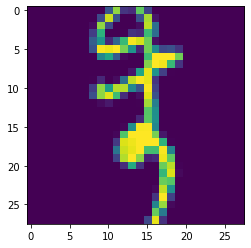

In [46]:
# let's see the image at index 0
plt.figure()
plt.imshow(k49_train_images[0])
plt.show()

In [47]:
# visually, this one look like 'ma'
# so according to the classmap
# it should be type 30
k49_train_labels[0]

30

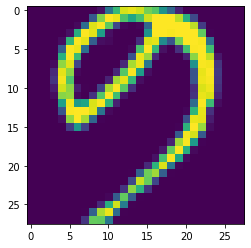

In [48]:
# let's see the image at index 11
plt.figure()
plt.imshow(k49_train_images[11])
plt.show()

In [49]:
# visually, we can see using the classmap
# that this one looks like 'no'
# so according to the classmap
# it should be type 24
k49_train_labels[11]

24

40
る ru


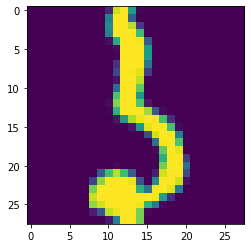

47
ん n


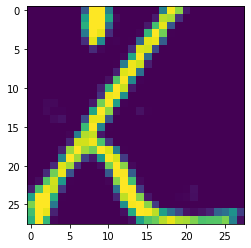

39
り ri


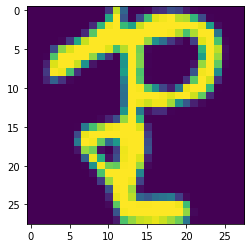

16
ち chi


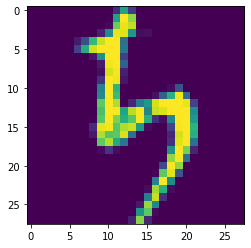

27
ふ fu


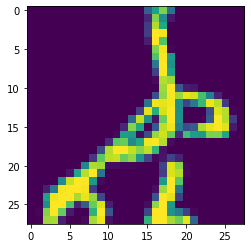

15
た ta


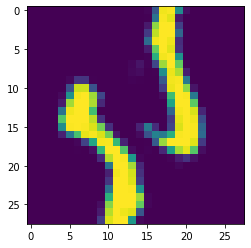

1
い i


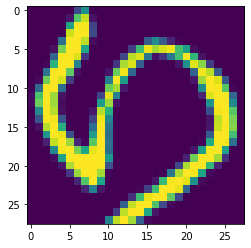

36
ゆ yu


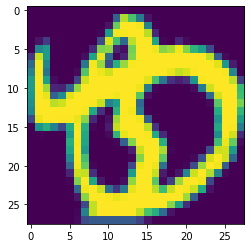

46
を wo


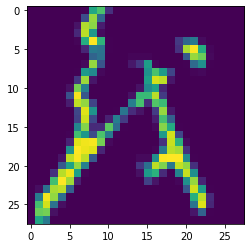

34
も mo


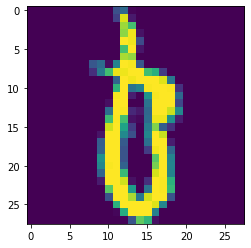

31
み mi


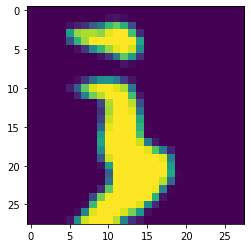

47
ん n


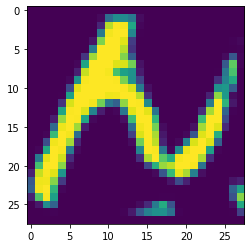

7
く ku


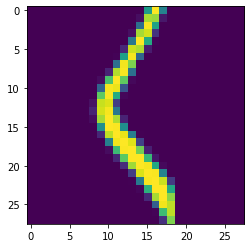

1
い i


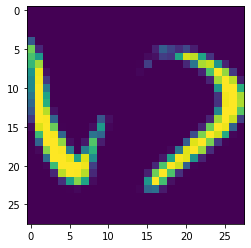

43
わ wa


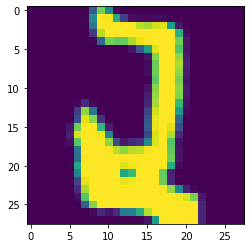

38
ら ra


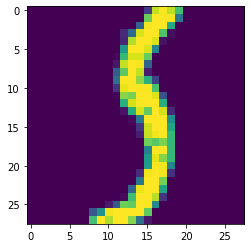

22
ぬ nu


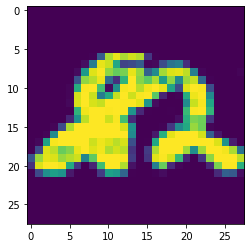

39
り ri


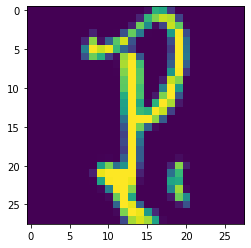

40
る ru


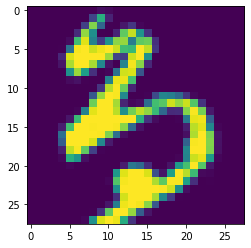

14
そ so


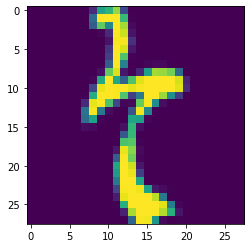

In [50]:
# next we print the class number, the written character, and the phonetic
# for index numbers 80 through 100:
for i in range(80,100):
    print(k49_train_labels[i])
    print(df_k49_classmap.loc[k49_train_labels[i],'char'], df_k49_classmap.loc[k49_train_labels[i],'phonetic'])
    plt.figure()
    plt.imshow(k49_train_images[i])
    plt.show()
    
    i+=1

In [51]:
# For the 2nd dataset with 49 classes
# we now we have verified visually that data is what we want:
# images of 49 different kuzushiji characters

# next we convert k49_train_labels numpy array to a dataframe
# in order to inspect the dataset further:

df_k49_train_labels = pd.DataFrame(k49_train_labels)

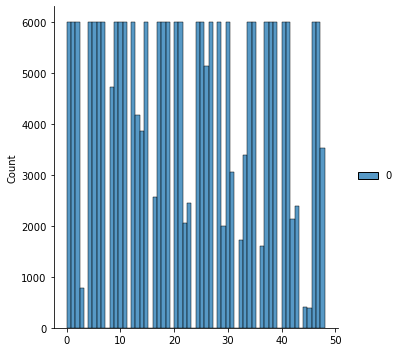

In [52]:
# lets see how the character data is distributed among the 49 classes:
sns.displot(df_k49_train_labels)

In [53]:
df_k49_train_labels[0].value_counts().sort_index()

0     6000
1     6000
2     6000
3      777
4     6000
5     6000
6     6000
7     6000
8     4714
9     6000
10    6000
11    6000
12    6000
13    4165
14    3867
15    6000
16    2565
17    6000
18    6000
19    6000
20    6000
21    6000
22    2063
23    2451
24    6000
25    6000
26    5132
27    6000
28    6000
29    1993
30    6000
31    3060
32    1718
33    3394
34    6000
35    6000
36    1598
37    6000
38    6000
39    6000
40    6000
41    6000
42    2139
43    2397
44     417
45     392
46    6000
47    6000
48    3523
Name: 0, dtype: int64

In [54]:
# so we confirm that many of the classes do not have 6,000 in the second data 
# set so the data set is not balanced

In [55]:
# the final dataset includes Kanji characters
# this data has 3832 different classes and
# consists of 140,426 images

# this dataset is not as processed as the other two:
# it is just a bunch of png images in a directory
# inside an archive file

# we download the archive:

!wget http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
!mv kkanji.tar?raw=True kkanji.tar
!ls -lahr kkanji.tar

--2021-06-10 15:52:08--  http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324290560 (309M) [application/x-tar]
Saving to: ‘kkanji.tar?raw=True’

kkanji.tar?raw=True 100%[===================>] 309.27M  8.63MB/s    in 35s     

2021-06-10 15:52:43 (8.92 MB/s) - ‘kkanji.tar?raw=True’ saved [324290560/324290560]

-rw-rw---- 1 wsuser watsonstudio 310M Dec  8  2018 kkanji.tar


In [56]:
# next, unarchive and set up the numpy arrays
# for the third (kanji) dataset

# first we'll set up the classmap for the 
# kanji dataset

In [57]:
# list the contents of the archive
# limit output to the first 70 files

!tar -tf kkanji.tar | head -70

kkanji2/
kkanji2/U+5B87/
kkanji2/U+5B87/72d56fcb33d10fe0.png
kkanji2/U+5B87/75f7923797777c74.png
kkanji2/U+5B87/69d6becd4f8f2d61.png
kkanji2/U+5B87/522dd01c5f9573f5.png
kkanji2/U+5B87/36aadd8d92c64049.png
kkanji2/U+5B87/58f75629e53b9e63.png
kkanji2/U+5B87/557950fbb39b019b.png
kkanji2/U+5B87/c4ca643dbc0299b6.png
kkanji2/U+5B87/02f161e7e7a3c364.png
kkanji2/U+5B87/c45553bb4a35c8d4.png
kkanji2/U+5B87/ffa955bd6cb43af8.png
kkanji2/U+5B87/d0387f14448f2a95.png
kkanji2/U+5B87/d8c4a0dbd99fc02f.png
kkanji2/U+5B87/419beef7f2c593da.png
kkanji2/U+5B87/f2308287339f973d.png
kkanji2/U+5B87/f885e3a957b99e8e.png
kkanji2/U+5B87/f5e7a417e3d831d8.png
kkanji2/U+5B87/17681a9b66db23e0.png
kkanji2/U+5B87/cc2b8cd01c984262.png
kkanji2/U+5B87/3e76b512ef42c8f2.png
kkanji2/U+5B87/49276561d0ca08e0.png
kkanji2/U+5B87/a169cf27462e020d.png
kkanji2/U+5B87/61b85600b3fdbea9.png
kkanji2/U+5B87/112b17b885fbfa61.png
kkanji2/U+5B87/99654e0e2e597032.png
kkanji2/U+5B87/7af7faf202121801.png
kkanji2/U+5B87/8a6b7ea64d025e6d.png
kka

In [58]:
# so the format of the data is that the individual images exist
# in folders whose names are the codepoint for the image category
# these folder names will be the basis for the class Index for each image

# next lets extract:

!tar -xf kkanji.tar

In [59]:
# checking whats in the current working directory:

!ls -al

total 445948
drwxr-x---    5 wsuser watsonstudio      4096 Jun 10 15:53 .
drwx------    1 wsuser watsonstudio      4096 Jun 10 15:46 ..
-rw-rw----    1 wsuser watsonstudio  10971201 Feb  4  2019 k49-test-imgs.npz
-rw-rw----    1 wsuser watsonstudio     27450 Feb  4  2019 k49-test-labels.npz
-rw-rw----    1 wsuser watsonstudio  66117696 Feb  4  2019 k49-train-imgs.npz
-rw-rw----    1 wsuser watsonstudio    164485 Feb  4  2019 k49-train-labels.npz
drwxr-x--- 3834 wsuser watsonstudio     86016 Dec  8  2018 kkanji2
-rw-rw----    1 wsuser watsonstudio 324290560 Dec  8  2018 kkanji.tar
drwxrwx---    2 wsuser watsonstudio      4096 Jun 10 15:48 kmnistdata
-rw-rw----    1 wsuser watsonstudio   7840016 Feb  4  2019 t10k-images-idx3-ubyte
-rw-rw----    1 wsuser watsonstudio     10008 Feb  4  2019 t10k-labels-idx1-ubyte
-rw-rw----    1 wsuser watsonstudio  47040016 Feb  4  2019 train-images-idx3-ubyte
-rw-rw----    1 wsuser watsonstudio     60008 Feb  4  2019 train-labels-idx1-ubyte
drwxr-x---   

In [60]:
# now list out the first 50 folder names in the directory kkanji2
# the folder names are also the codepoint of each of the characters:

!ls kkanji2 | head -50

U+241C6
U+24FA3
U+25DA1
U+27752
U+29780
U+29DDA
U+29E75
U+4093
U+4453
U+4543
U+4572
U+4C61
U+4C99
U+4E00
U+4E01
U+4E03
U+4E07
U+4E08
U+4E09
U+4E0A
U+4E0B
U+4E0D
U+4E0E
U+4E11
U+4E14
U+4E16
U+4E17
U+4E18
U+4E19
U+4E1E
U+4E21
U+4E26
U+4E2D
U+4E32
U+4E38
U+4E39
U+4E3B
U+4E3C
U+4E42
U+4E43
U+4E45
U+4E4B
U+4E4D
U+4E4E
U+4E4F
U+4E57
U+4E58
U+4E59
U+4E5D
U+4E5E
ls: write error: Broken pipe


In [61]:
# put the codepoints in a file
# let the first line of the file be name
# of the column in the dataframe we are creating
!echo codepoint > codepoints.csv
!ls kkanji2 >> codepoints.csv
!cat codepoints.csv | head -50

codepoint
U+241C6
U+24FA3
U+25DA1
U+27752
U+29780
U+29DDA
U+29E75
U+4093
U+4453
U+4543
U+4572
U+4C61
U+4C99
U+4E00
U+4E01
U+4E03
U+4E07
U+4E08
U+4E09
U+4E0A
U+4E0B
U+4E0D
U+4E0E
U+4E11
U+4E14
U+4E16
U+4E17
U+4E18
U+4E19
U+4E1E
U+4E21
U+4E26
U+4E2D
U+4E32
U+4E38
U+4E39
U+4E3B
U+4E3C
U+4E42
U+4E43
U+4E45
U+4E4B
U+4E4D
U+4E4E
U+4E4F
U+4E57
U+4E58
U+4E59
U+4E5D


In [62]:
!ls -al

total 445976
drwxr-x---    5 wsuser watsonstudio      4096 Jun 10 15:53 .
drwx------    1 wsuser watsonstudio      4096 Jun 10 15:46 ..
-rw-rw----    1 wsuser watsonstudio     26841 Jun 10 15:53 codepoints.csv
-rw-rw----    1 wsuser watsonstudio  10971201 Feb  4  2019 k49-test-imgs.npz
-rw-rw----    1 wsuser watsonstudio     27450 Feb  4  2019 k49-test-labels.npz
-rw-rw----    1 wsuser watsonstudio  66117696 Feb  4  2019 k49-train-imgs.npz
-rw-rw----    1 wsuser watsonstudio    164485 Feb  4  2019 k49-train-labels.npz
drwxr-x--- 3834 wsuser watsonstudio     86016 Dec  8  2018 kkanji2
-rw-rw----    1 wsuser watsonstudio 324290560 Dec  8  2018 kkanji.tar
drwxrwx---    2 wsuser watsonstudio      4096 Jun 10 15:48 kmnistdata
-rw-rw----    1 wsuser watsonstudio   7840016 Feb  4  2019 t10k-images-idx3-ubyte
-rw-rw----    1 wsuser watsonstudio     10008 Feb  4  2019 t10k-labels-idx1-ubyte
-rw-rw----    1 wsuser watsonstudio  47040016 Feb  4  2019 train-images-idx3-ubyte
-rw-rw----    1 wsuser

In [63]:
print (os.path.abspath("codepoints.csv"))

/home/wsuser/work/codepoints.csv


In [64]:
# read all the lines of the file into pandas dataframe
# including the column header which is already in the file

df_kanji_classmap = pd.read_csv("codepoints.csv")

In [65]:
df_kanji_classmap

,codepoint
0,U+241C6
1,U+24FA3
2,U+25DA1
3,U+27752
4,U+29780
...,...
3827,U+FA38
3828,U+FA45
3829,U+FA4A
3830,U+FA55


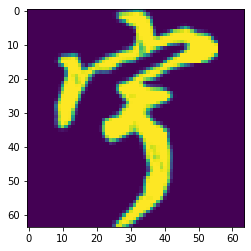

In [66]:
#read the first listed image in the first folder and display it
img = mping.imread('kkanji2/U+5B87/72d56fcb33d10fe0.png')
plt.imshow(img)
plt.show()

In [67]:
# verify the full path for the folder containing the images
print (os.path.abspath("kkanji2/"))

/home/wsuser/work/kkanji2


In [68]:
# create a pandas dataframe that contains the codepoint for each image, 
# and its full path in the os and display that dataframe

data = []
dir = os.path.realpath('/home/wsuser/work/kkanji2')
for r, d, f in os.walk(dir):
    for file in f:
        if ".png" in file:
            data.append((r.split('/')[-1],os.path.join(r,file)))
df_kanji2 = pd.DataFrame(data, columns=['codepoint', 'image_file_path']).sort_values(by=['codepoint'], ignore_index = True)
df_kanji2

,codepoint,image_file_path
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a...
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec...
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc9...
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70...
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd...
...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/83081d31818c4...
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/bfc275b30e5b2...
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/830a4ce68f658...
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/679e4b2f026f6...


In [69]:
# show the os path of the first image
df_kanji2['image_file_path'][0]

'/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a4538.png'

In [70]:
# read the image using Pillow
pimage = Image.open(df_kanji2['image_file_path'][0])

In [71]:
# show some information about the image:
print(pimage.format)

PNG


In [72]:
print(pimage.size)

(64, 64)


In [73]:
print(pimage.mode)

L


In [74]:
# it is important to know that the image is 64 x 64 pixels, unlike the first two datasets

In [75]:
# next read the image using matplotlib

In [76]:
img = image.imread(df_kanji2['image_file_path'][0])

In [77]:
print(img.dtype)

float32


In [78]:
print(img.shape)

(64, 64)


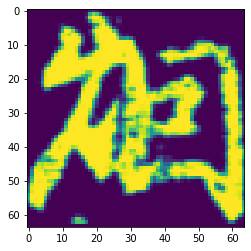

In [79]:
plt.imshow(img)

In [80]:
# next we want to try to convert this image into a numpy array

In [81]:
image_nparray = asarray(img)

In [82]:
# verify we have created a numpy array
print(type(image_nparray))

<class 'numpy.ndarray'>


In [83]:
# verify the numpy array is the correct dimensions:
print(image_nparray.shape)

(64, 64)


In [84]:
image_nparray

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.6156863 , 0.07058824,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0627451 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [85]:
# convert the pandas dataframe into a pyspark dataframe
df_kanji2_pyspk = spark.createDataFrame(df_kanji2)

In [86]:
# our data has 3,831 different classes each with unique string names
# which is based on their character codepoints
# but we want simple numeric class index
# so we instantiate a StringIndexer in spark:

indexer = StringIndexer(inputCol="codepoint",outputCol="classIndex")
indexed_df = indexer.fit(df_kanji2_pyspk).transform(df_kanji2_pyspk)
indexed_df.show()

+---------+--------------------+----------+
|codepoint|     image_file_path|classIndex|
+---------+--------------------+----------+
|  U+241C6|/home/wsuser/work...|    2606.0|
|  U+241C6|/home/wsuser/work...|    2606.0|
|  U+24FA3|/home/wsuser/work...|    2607.0|
|  U+24FA3|/home/wsuser/work...|    2607.0|
|  U+25DA1|/home/wsuser/work...|    3017.0|
|  U+27752|/home/wsuser/work...|    1966.0|
|  U+27752|/home/wsuser/work...|    1966.0|
|  U+27752|/home/wsuser/work...|    1966.0|
|  U+27752|/home/wsuser/work...|    1966.0|
|  U+27752|/home/wsuser/work...|    1966.0|
|  U+29780|/home/wsuser/work...|    3018.0|
|  U+29DDA|/home/wsuser/work...|    3019.0|
|  U+29E75|/home/wsuser/work...|    3020.0|
|   U+4093|/home/wsuser/work...|    3021.0|
|   U+4453|/home/wsuser/work...|     680.0|
|   U+4453|/home/wsuser/work...|     680.0|
|   U+4453|/home/wsuser/work...|     680.0|
|   U+4453|/home/wsuser/work...|     680.0|
|   U+4453|/home/wsuser/work...|     680.0|
|   U+4453|/home/wsuser/work...|

In [87]:
# transform back to pandas dataframe:
df_kanji2 = indexed_df.toPandas()

In [88]:
df_kanji2

,codepoint,image_file_path,classIndex
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a...,2606.0
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec...,2606.0
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc9...,2607.0
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70...,2607.0
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd...,3017.0
...,...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/83081d31818c4...,1041.0
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/bfc275b30e5b2...,1041.0
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/830a4ce68f658...,1041.0
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/679e4b2f026f6...,3016.0


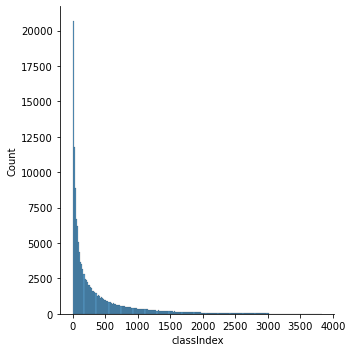

In [89]:
# now it is easy to explore the distribution between the classes:
# note that the StringIndexer took frequency into account when
# creating the classes, so the lowest indexes have the largest count:

sns.displot(df_kanji2['classIndex'])

In [90]:
df_kanji2['classIndex'].value_counts().sort_index()

0.0       1768
1.0       1766
2.0       1674
3.0       1575
4.0       1451
          ... 
3827.0       1
3828.0       1
3829.0       1
3830.0       1
3831.0       1
Name: classIndex, Length: 3832, dtype: int64

Dataframe Index:  0
Class Index:  2606.0


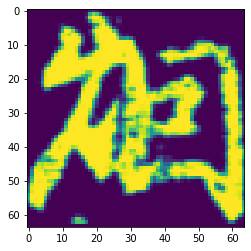

Dataframe Index:  1
Class Index:  2606.0


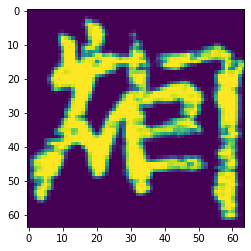

Dataframe Index:  2
Class Index:  2607.0


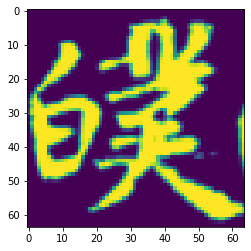

Dataframe Index:  3
Class Index:  2607.0


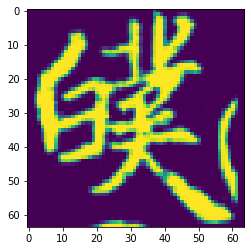

Dataframe Index:  4
Class Index:  3017.0


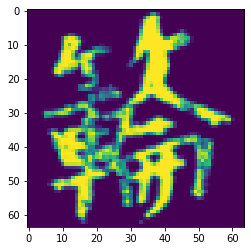

Dataframe Index:  5
Class Index:  1966.0


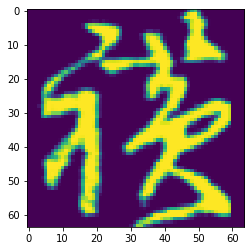

Dataframe Index:  6
Class Index:  1966.0


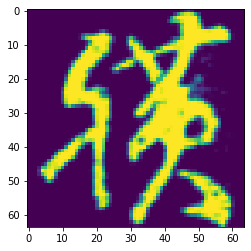

Dataframe Index:  7
Class Index:  1966.0


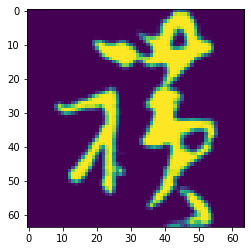

Dataframe Index:  8
Class Index:  1966.0


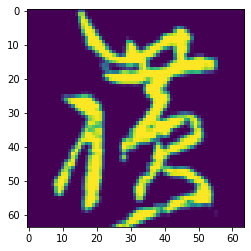

Dataframe Index:  9
Class Index:  1966.0


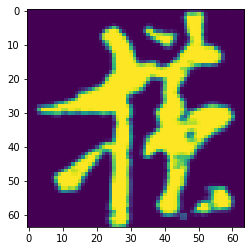

Dataframe Index:  10
Class Index:  3018.0


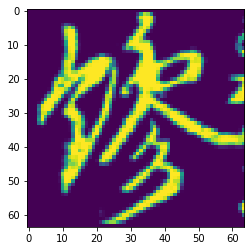

Dataframe Index:  11
Class Index:  3019.0


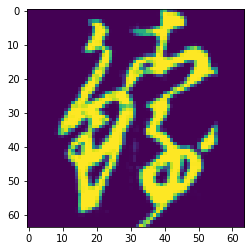

Dataframe Index:  12
Class Index:  3020.0


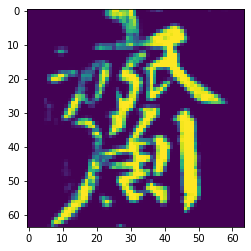

Dataframe Index:  13
Class Index:  3021.0


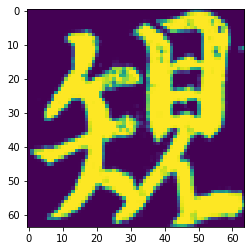

Dataframe Index:  14
Class Index:  680.0


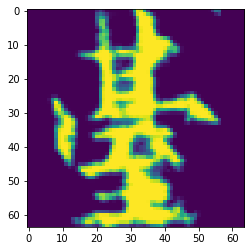

Dataframe Index:  15
Class Index:  680.0


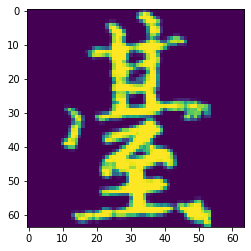

Dataframe Index:  16
Class Index:  680.0


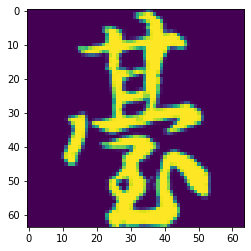

Dataframe Index:  17
Class Index:  680.0


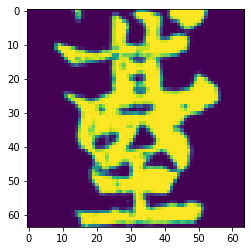

Dataframe Index:  18
Class Index:  680.0


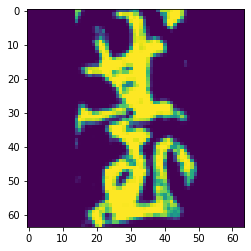

Dataframe Index:  19
Class Index:  680.0


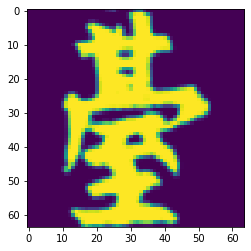

Dataframe Index:  20
Class Index:  680.0


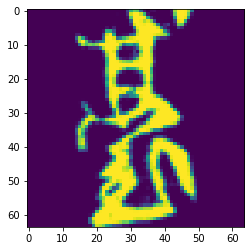

Dataframe Index:  21
Class Index:  680.0


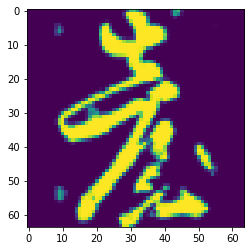

Dataframe Index:  22
Class Index:  680.0


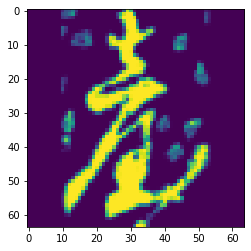

Dataframe Index:  23
Class Index:  680.0


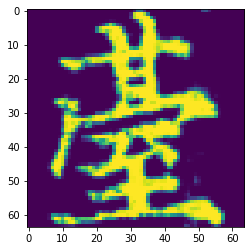

Dataframe Index:  24
Class Index:  680.0


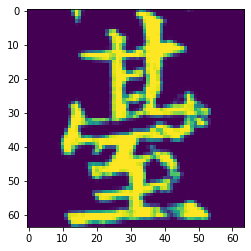

Dataframe Index:  25
Class Index:  680.0


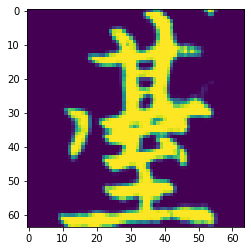

Dataframe Index:  26
Class Index:  680.0


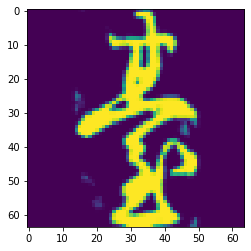

Dataframe Index:  27
Class Index:  680.0


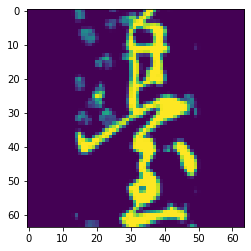

Dataframe Index:  28
Class Index:  680.0


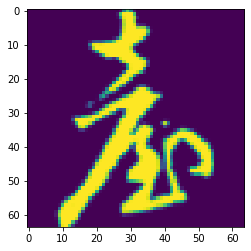

Dataframe Index:  29
Class Index:  680.0


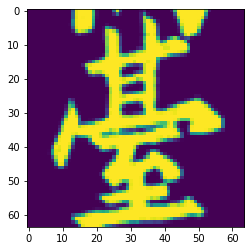

Dataframe Index:  30
Class Index:  680.0


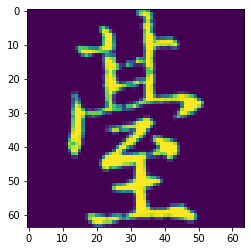

Dataframe Index:  31
Class Index:  680.0


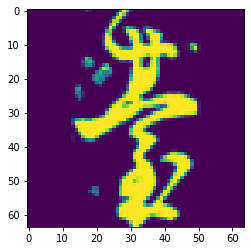

Dataframe Index:  32
Class Index:  680.0


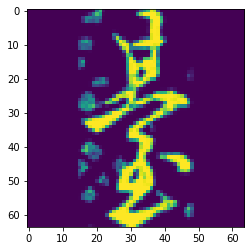

Dataframe Index:  33
Class Index:  680.0


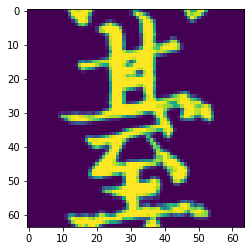

Dataframe Index:  34
Class Index:  680.0


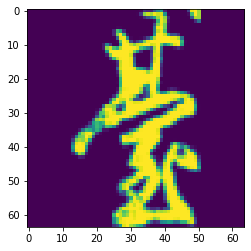

Dataframe Index:  35
Class Index:  680.0


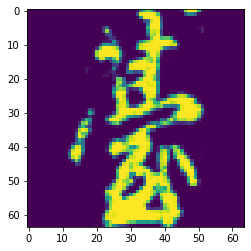

Dataframe Index:  36
Class Index:  680.0


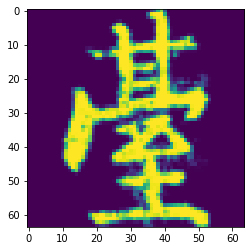

Dataframe Index:  37
Class Index:  680.0


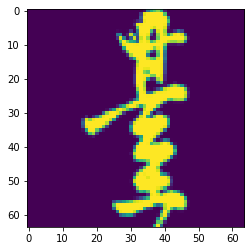

Dataframe Index:  38
Class Index:  680.0


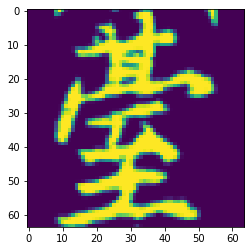

Dataframe Index:  39
Class Index:  680.0


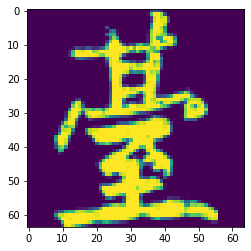

Dataframe Index:  40
Class Index:  680.0


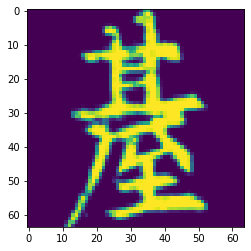

Dataframe Index:  41
Class Index:  680.0


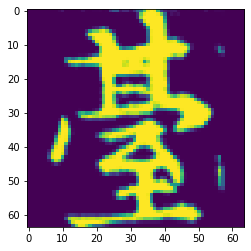

Dataframe Index:  42
Class Index:  680.0


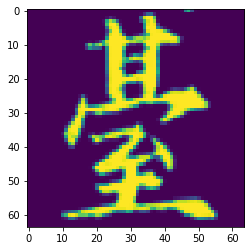

Dataframe Index:  43
Class Index:  680.0


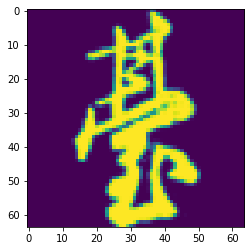

Dataframe Index:  44
Class Index:  680.0


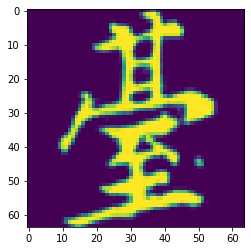

Dataframe Index:  45
Class Index:  680.0


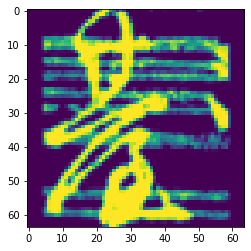

Dataframe Index:  46
Class Index:  680.0


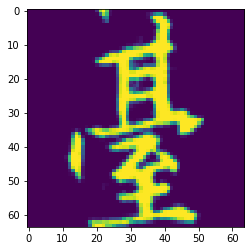

Dataframe Index:  47
Class Index:  680.0


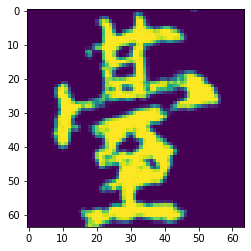

Dataframe Index:  48
Class Index:  680.0


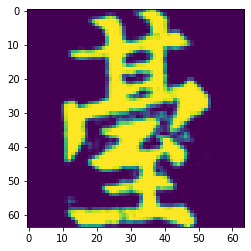

Dataframe Index:  49
Class Index:  680.0


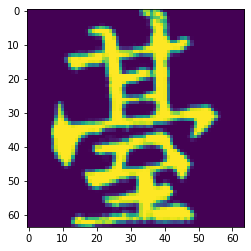

Dataframe Index:  50
Class Index:  680.0


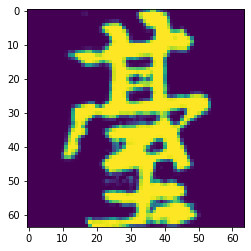

Dataframe Index:  51
Class Index:  680.0


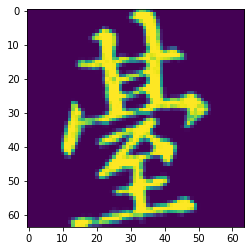

Dataframe Index:  52
Class Index:  680.0


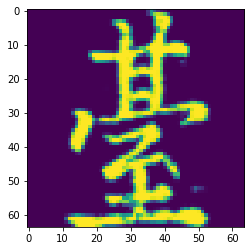

Dataframe Index:  53
Class Index:  3022.0


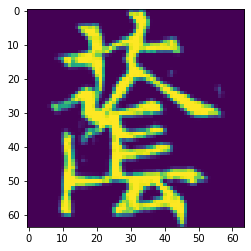

Dataframe Index:  54
Class Index:  3023.0


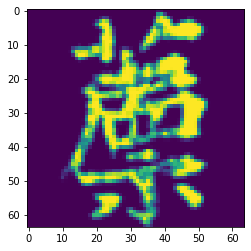

Dataframe Index:  55
Class Index:  3024.0


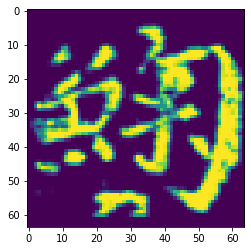

Dataframe Index:  56
Class Index:  3025.0


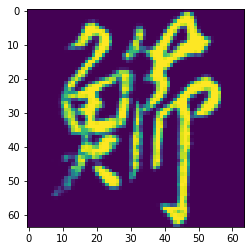

Dataframe Index:  57
Class Index:  0.0


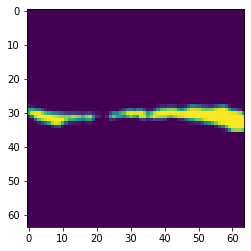

Dataframe Index:  58
Class Index:  0.0


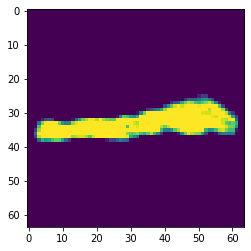

Dataframe Index:  59
Class Index:  0.0


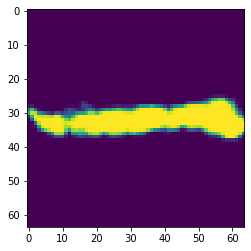

Dataframe Index:  60
Class Index:  0.0


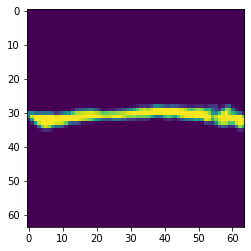

Dataframe Index:  61
Class Index:  0.0


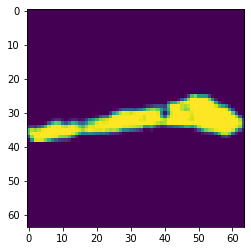

Dataframe Index:  62
Class Index:  0.0


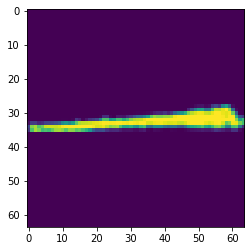

Dataframe Index:  63
Class Index:  0.0


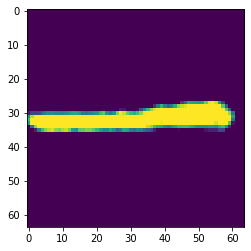

Dataframe Index:  64
Class Index:  0.0


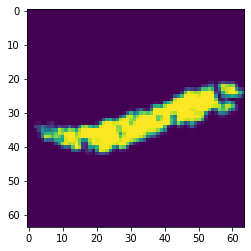

Dataframe Index:  65
Class Index:  0.0


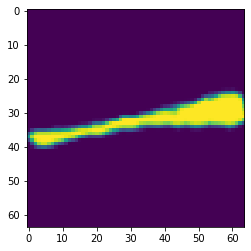

Dataframe Index:  66
Class Index:  0.0


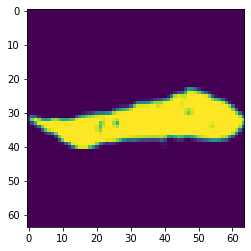

Dataframe Index:  67
Class Index:  0.0


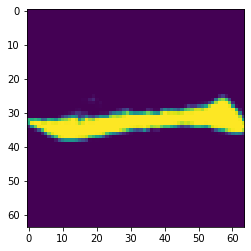

Dataframe Index:  68
Class Index:  0.0


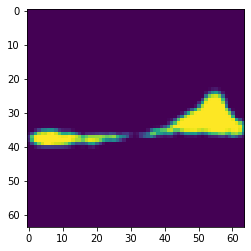

Dataframe Index:  69
Class Index:  0.0


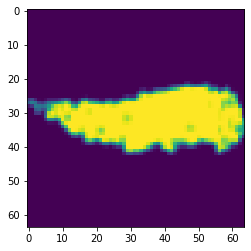

Dataframe Index:  70
Class Index:  0.0


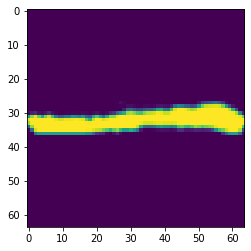

Dataframe Index:  71
Class Index:  0.0


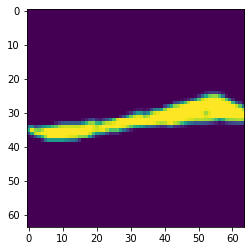

Dataframe Index:  72
Class Index:  0.0


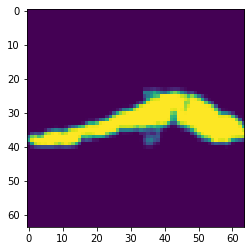

Dataframe Index:  73
Class Index:  0.0


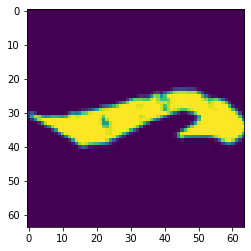

Dataframe Index:  74
Class Index:  0.0


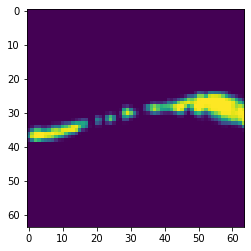

Dataframe Index:  75
Class Index:  0.0


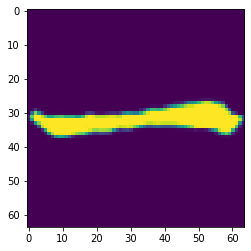

Dataframe Index:  76
Class Index:  0.0


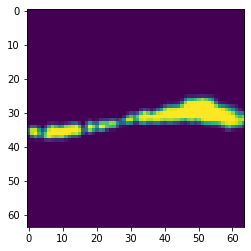

Dataframe Index:  77
Class Index:  0.0


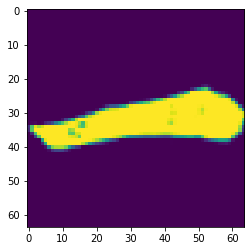

Dataframe Index:  78
Class Index:  0.0


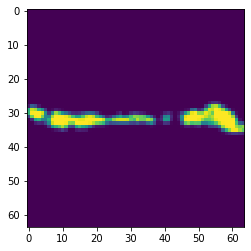

Dataframe Index:  79
Class Index:  0.0


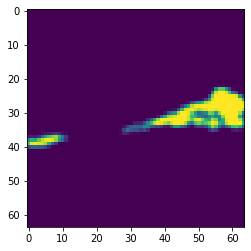

Dataframe Index:  80
Class Index:  0.0


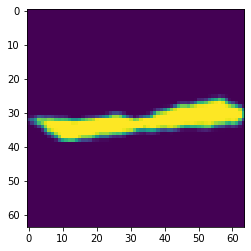

Dataframe Index:  81
Class Index:  0.0


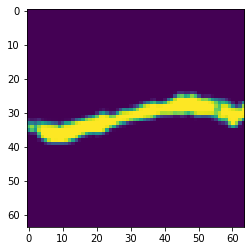

Dataframe Index:  82
Class Index:  0.0


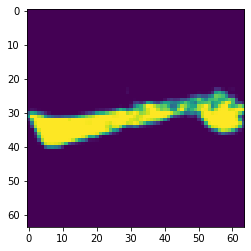

Dataframe Index:  83
Class Index:  0.0


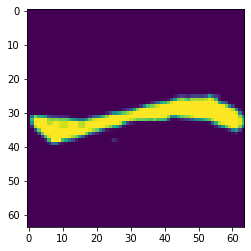

Dataframe Index:  84
Class Index:  0.0


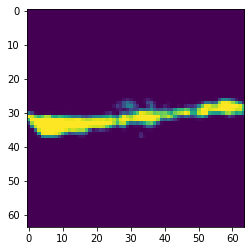

Dataframe Index:  85
Class Index:  0.0


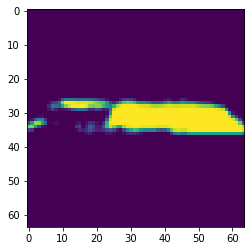

Dataframe Index:  86
Class Index:  0.0


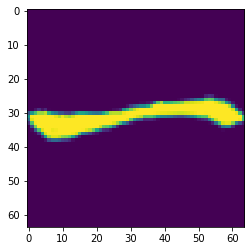

Dataframe Index:  87
Class Index:  0.0


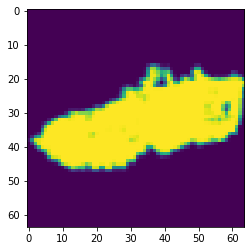

Dataframe Index:  88
Class Index:  0.0


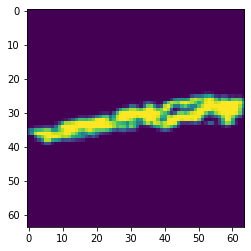

Dataframe Index:  89
Class Index:  0.0


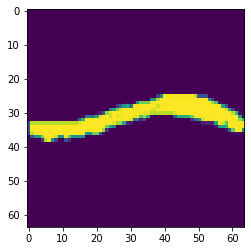

Dataframe Index:  90
Class Index:  0.0


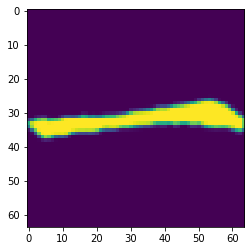

Dataframe Index:  91
Class Index:  0.0


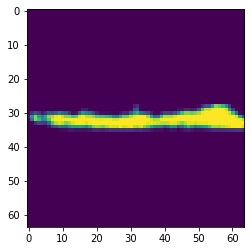

Dataframe Index:  92
Class Index:  0.0


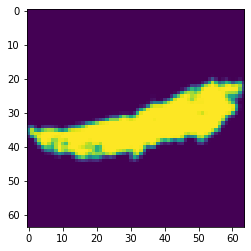

Dataframe Index:  93
Class Index:  0.0


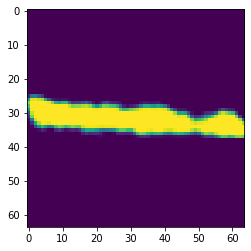

Dataframe Index:  94
Class Index:  0.0


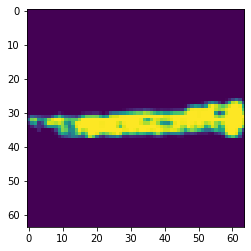

Dataframe Index:  95
Class Index:  0.0


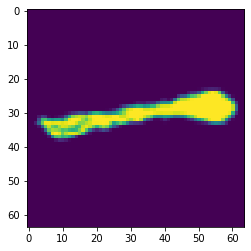

Dataframe Index:  96
Class Index:  0.0


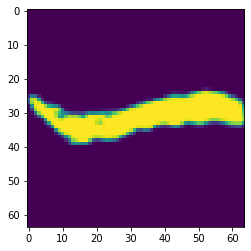

Dataframe Index:  97
Class Index:  0.0


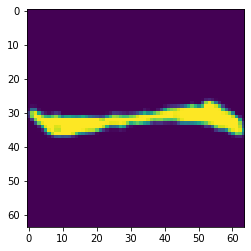

Dataframe Index:  98
Class Index:  0.0


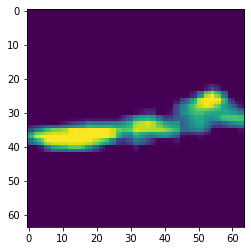

Dataframe Index:  99
Class Index:  0.0


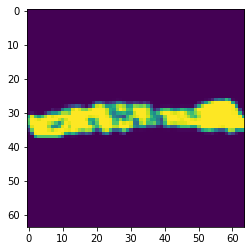

In [91]:
# walk through the dataframe and display an image and the
# image's class Index

for i in range(0,100):
    print('Dataframe Index: ', i)
    print('Class Index: ', df_kanji2['classIndex'][i])
    imag = image.imread(df_kanji2['image_file_path'][i])
    plt.figure()
    plt.imshow(imag)
    plt.show()
    
    i+=1

In [92]:
# so in our exploration of the 3rd dataset, we can see
# that the data set contains more complex images and 
# that they are larger, and also that this 3rd dataset
# is also an unbalanced dataset i.e. there are not
# the same numbers of each class.

[end]